In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)


In [2]:
# Q1. Load the transaction dataset into a Pandas DataFrame and display the first five rows.

import pandas as pd
path="/content/drive/MyDrive/machine learning/9108 Tanishka singh financial transaction fraud detection .csv"
df=pd.read_csv(path)
df.head()





,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3.0,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7.0,0.96,ACH,172.52.47.194,D2622631
2,T100002,2023-05-12T11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,True,card_fraud,NaN,-1.78,20.0,0.89,card,185.98.35.23,D4823498
3,T100003,2023-10-10T06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,True,card_fraud,NaN,-0.60,6.0,0.37,wire_transfer,107.136.36.87,D9961380
4,T100004,2023-09-24T08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13.0,0.27,ACH,108.161.108.255,D7637601


In [3]:
print(df.shape)
print(df["is_fraud"].value_counts())

(1000, 18)
is_fraud
False    860
True     140
Name: count, dtype: int64


In [4]:
# Q2. Check the total number of records and columns in the dataset.

df.shape


(1000, 18)

In [5]:
# Q3. Display all column names along with their data types.

df.dtypes


,0
transaction_id,object
timestamp,object
sender_account,object
receiver_account,object
amount,float64
transaction_type,object
merchant_category,object
location,object
device_used,object
is_fraud,bool


In [6]:
# Q4. Convert the timestamp column to a proper datetime format.

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")


In [7]:
# Q5. Check for missing or empty values in fraud-related columns (fraud_type, is_fraud).

df[["fraud_type","is_fraud"]].isnull().sum()


,0
fraud_type,861
is_fraud,0


In [8]:
# Q6. Rename column names to follow snake_case format.

df.columns = df.columns.str.lower().str.strip().str.replace(" ","_")
df.columns


Index(['transaction_id', 'timestamp', 'sender_account', 'receiver_account',
       'amount', 'transaction_type', 'merchant_category', 'location',
       'device_used', 'is_fraud', 'fraud_type', 'time_since_last_transaction',
       'spending_deviation_score', 'velocity_score', 'geo_anomaly_score',
       'payment_channel', 'ip_address', 'device_hash'],
      dtype='object')

In [9]:
# Q7. Convert is_fraud to a boolean data type.

df["is_fraud"] = df["is_fraud"].astype(str).str.upper().map({"TRUE":True,"FALSE":False})


In [10]:
# Q8. Convert numerical columns (amount, scores, time_since_last_transaction) to numeric type.

num_cols = [
    "amount",
    "time_since_last_transaction",
    "spending_deviation_score",
    "velocity_score",
    "geo_anomaly_score"
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")


In [11]:
# Q9. Create a new column transaction_hour extracted from the timestamp.

df["transaction_hour"] = df["timestamp"].dt.hour


In [12]:
# Q10. Create a new column risk_score as the average of velocity_score and geo_anomaly_score.

df["risk_score"] = (df["velocity_score"] + df["geo_anomaly_score"]) / 2


In [13]:
# Q11. Filter transactions with an amount greater than 1000.

df[df["amount"] > 1000]


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,True,card_fraud,NaN,-1.78,20.0,0.89,card,185.98.35.23,D4823498,11.0,10.445
3,T100003,2023-10-10 06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,True,card_fraud,NaN,-0.60,6.0,0.37,wire_transfer,107.136.36.87,D9961380,6.0,3.185
10,T100010,2023-08-04 00:35:03.745267,ACC717024,ACC330914,1237.07,deposit,travel,New York,web,True,card_fraud,NaN,1.64,3.0,0.51,card,142.248.109.67,D8930103,0.0,1.755
14,T100014,2023-03-11 13:30:19.142152,ACC161324,ACC707314,1283.35,deposit,restaurant,New York,mobile,True,card_fraud,NaN,-1.96,6.0,0.06,UPI,41.95.35.34,D4946066,13.0,3.030
15,T100015,2023-05-29 03:04:25.786373,ACC358175,ACC707040,1258.92,deposit,travel,Dubai,atm,True,card_fraud,NaN,-0.04,7.0,0.67,wire_transfer,160.122.135.202,D3195773,3.0,3.835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,T100960,2023-10-12 19:29:14.071775,ACC144206,ACC302310,1319.44,deposit,utilities,Toronto,pos,True,card_fraud,NaN,0.32,1.0,0.39,UPI,233.37.164.108,D2676811,19.0,0.695
962,T100962,2023-10-31 19:59:23.531794,ACC886078,ACC142301,2259.78,deposit,utilities,Sydney,mobile,True,card_fraud,NaN,0.17,8.0,0.48,UPI,69.208.23.108,D4921631,19.0,4.240
963,T100963,2023-08-25 06:23:15.550960,ACC859019,ACC230167,1079.96,deposit,travel,Toronto,pos,True,card_fraud,NaN,-0.90,20.0,0.82,card,188.33.148.146,D4049729,6.0,10.410
977,T100977,2023-05-18 11:35:40.230013,ACC328855,ACC569226,1178.60,deposit,grocery,Sydney,atm,True,card_fraud,NaN,1.03,6.0,0.86,card,165.24.72.202,D5932778,11.0,3.430


In [14]:
# Q12. Filter transactions marked as fraudulent.

df[df["is_fraud"] == True]


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,True,card_fraud,NaN,-1.78,20.0,0.89,card,185.98.35.23,D4823498,11.0,10.445
3,T100003,2023-10-10 06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,True,card_fraud,NaN,-0.60,6.0,0.37,wire_transfer,107.136.36.87,D9961380,6.0,3.185
10,T100010,2023-08-04 00:35:03.745267,ACC717024,ACC330914,1237.07,deposit,travel,New York,web,True,card_fraud,NaN,1.64,3.0,0.51,card,142.248.109.67,D8930103,0.0,1.755
14,T100014,2023-03-11 13:30:19.142152,ACC161324,ACC707314,1283.35,deposit,restaurant,New York,mobile,True,card_fraud,NaN,-1.96,6.0,0.06,UPI,41.95.35.34,D4946066,13.0,3.030
15,T100015,2023-05-29 03:04:25.786373,ACC358175,ACC707040,1258.92,deposit,travel,Dubai,atm,True,card_fraud,NaN,-0.04,7.0,0.67,wire_transfer,160.122.135.202,D3195773,3.0,3.835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,T100962,2023-10-31 19:59:23.531794,ACC886078,ACC142301,2259.78,deposit,utilities,Sydney,mobile,True,card_fraud,NaN,0.17,8.0,0.48,UPI,69.208.23.108,D4921631,19.0,4.240
963,T100963,2023-08-25 06:23:15.550960,ACC859019,ACC230167,1079.96,deposit,travel,Toronto,pos,True,card_fraud,NaN,-0.90,20.0,0.82,card,188.33.148.146,D4049729,6.0,10.410
977,T100977,2023-05-18 11:35:40.230013,ACC328855,ACC569226,1178.60,deposit,grocery,Sydney,atm,True,card_fraud,NaN,1.03,6.0,0.86,card,165.24.72.202,D5932778,11.0,3.430
995,T100995,2023-12-17 15:50:59.446208,ACC987729,ACC256957,2130.27,deposit,grocery,London,mobile,True,card_fraud,NaN,0.29,6.0,0.46,wire_transfer,62.242.30.67,D9019741,15.0,3.230


In [15]:
# Q13. Filter transactions performed using mobile devices.

df[df["device_used"] == "mobile"]


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
0,T100000,2023-08-22 09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3.0,0.22,card,13.101.214.112,D8536477,9.0,1.610
4,T100004,2023-09-24 08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13.0,0.27,ACH,108.161.108.255,D7637601,8.0,6.635
14,T100014,2023-03-11 13:30:19.142152,ACC161324,ACC707314,1283.35,deposit,restaurant,New York,mobile,True,card_fraud,NaN,-1.96,6.0,0.06,UPI,41.95.35.34,D4946066,13.0,3.030
16,T100016,2023-09-03 13:00:22.871266,ACC579434,ACC431535,1444.64,deposit,retail,Singapore,mobile,True,card_fraud,NaN,-1.15,5.0,0.93,card,35.125.189.145,D3646552,13.0,2.965
18,T100018,2023-03-17 03:30:44.841559,ACC994343,ACC376807,4.49,payment,grocery,New York,mobile,False,NaN,NaN,0.14,11.0,0.77,UPI,134.82.226.218,D1162230,3.0,5.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,T100970,2023-10-12 04:26:06.149229,ACC667770,ACC256187,238.32,withdrawal,grocery,Sydney,mobile,False,NaN,NaN,0.30,8.0,0.00,card,222.200.199.32,D1925278,4.0,4.000
986,T100986,2023-07-17 17:00:21.913256,ACC295833,ACC127491,65.80,payment,grocery,Dubai,mobile,False,NaN,NaN,-0.28,15.0,0.49,card,252.196.76.223,D9486008,17.0,7.745
990,T100990,2023-07-20 02:33:18.335349,ACC208110,ACC456710,77.22,payment,entertainment,Sydney,mobile,False,NaN,NaN,0.66,16.0,0.18,wire_transfer,175.199.85.87,D7772146,2.0,8.090
993,T100993,2023-03-02 09:46:42.364113,ACC646877,ACC973489,10.62,transfer,utilities,Sydney,mobile,False,NaN,NaN,-0.64,12.0,0.21,card,157.45.166.150,D8611432,9.0,6.105


In [16]:
# Q14. Filter transactions where velocity_score is greater than 10.

df[df["velocity_score"] > 10]


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,True,card_fraud,NaN,-1.78,20.0,0.89,card,185.98.35.23,D4823498,11.0,10.445
4,T100004,2023-09-24 08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13.0,0.27,ACH,108.161.108.255,D7637601,8.0,6.635
5,T100005,2023-11-20 17:49:27.940971,ACC581141,ACC249811,58.77,transfer,entertainment,Berlin,atm,False,NaN,NaN,-1.63,19.0,0.40,UPI,112.70.252.46,D1790481,17.0,9.700
9,T100009,2023-07-13 09:25:20.560022,ACC543692,ACC322086,203.05,withdrawal,grocery,Dubai,atm,False,NaN,NaN,0.59,17.0,0.45,UPI,126.115.32.173,D1352896,9.0,8.725
11,T100011,2023-03-31 07:39:21.036192,ACC946721,ACC526833,465.45,withdrawal,travel,London,pos,False,NaN,NaN,-1.11,14.0,0.41,wire_transfer,27.50.31.206,D6692553,7.0,7.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,T100991,2023-12-12 14:31:37.557326,ACC828338,ACC333067,15.77,transfer,restaurant,London,web,False,NaN,NaN,1.56,18.0,0.71,card,189.187.13.250,D9706284,14.0,9.355
993,T100993,2023-03-02 09:46:42.364113,ACC646877,ACC973489,10.62,transfer,utilities,Sydney,mobile,False,NaN,NaN,-0.64,12.0,0.21,card,157.45.166.150,D8611432,9.0,6.105
994,T100994,2023-02-09 15:53:53.711274,ACC312123,ACC212430,562.84,withdrawal,entertainment,Toronto,web,False,NaN,NaN,-1.91,17.0,0.10,UPI,218.229.162.23,D1269387,15.0,8.550
996,T100996,2023-01-03 21:55:27.779065,ACC236079,ACC346425,16.59,transfer,online,Tokyo,web,False,NaN,NaN,-2.07,14.0,0.42,wire_transfer,166.212.230.226,D5689870,21.0,7.210


In [17]:
# Q15. Filter transactions with high geo anomaly score (> 0.8).

df[df["geo_anomaly_score"] > 0.8]


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
1,T100001,2023-08-04 01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7.0,0.96,ACH,172.52.47.194,D2622631,1.0,3.980
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,True,card_fraud,NaN,-1.78,20.0,0.89,card,185.98.35.23,D4823498,11.0,10.445
8,T100008,2023-02-11 06:57:40.585720,ACC972064,ACC945964,16.00,transfer,utilities,New York,web,False,NaN,NaN,0.99,3.0,0.98,card,64.65.243.84,D5446912,6.0,1.990
16,T100016,2023-09-03 13:00:22.871266,ACC579434,ACC431535,1444.64,deposit,retail,Singapore,mobile,True,card_fraud,NaN,-1.15,5.0,0.93,card,35.125.189.145,D3646552,13.0,2.965
17,T100017,2023-06-10 15:29:48.694371,ACC837715,ACC417212,1120.17,deposit,grocery,London,web,True,card_fraud,NaN,-0.28,4.0,0.89,wire_transfer,79.139.144.107,D6752576,15.0,2.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,T100976,2023-01-05 02:13:06.643921,ACC810968,ACC206594,68.65,deposit,entertainment,New York,pos,False,NaN,NaN,0.20,17.0,0.98,card,162.67.239.253,D6787556,2.0,8.990
977,T100977,2023-05-18 11:35:40.230013,ACC328855,ACC569226,1178.60,deposit,grocery,Sydney,atm,True,card_fraud,NaN,1.03,6.0,0.86,card,165.24.72.202,D5932778,11.0,3.430
980,T100980,2023-03-27 21:39:11.320312,ACC966473,ACC342880,497.05,withdrawal,travel,Tokyo,atm,False,NaN,NaN,0.71,15.0,0.96,UPI,11.252.219.206,D2996404,21.0,7.980
982,T100982,2023-03-24 04:26:09.405115,ACC443818,ACC806617,0.01,withdrawal,travel,Dubai,atm,False,NaN,NaN,0.21,15.0,0.94,card,135.207.76.37,D9771756,4.0,7.970


In [18]:
# Q16. Filter transactions made using the UPI payment channel.

df[df["payment_channel"] == "UPI"]


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
5,T100005,2023-11-20 17:49:27.940971,ACC581141,ACC249811,58.77,transfer,entertainment,Berlin,atm,False,NaN,NaN,-1.63,19.0,0.40,UPI,112.70.252.46,D1790481,17.0,9.700
6,T100006,2023-11-11 11:15:41.359248,ACC757924,ACC267753,59.51,payment,travel,Dubai,pos,False,NaN,NaN,-2.62,1.0,0.68,UPI,58.136.174.57,D5924115,11.0,0.840
9,T100009,2023-07-13 09:25:20.560022,ACC543692,ACC322086,203.05,withdrawal,grocery,Dubai,atm,False,NaN,NaN,0.59,17.0,0.45,UPI,126.115.32.173,D1352896,9.0,8.725
14,T100014,2023-03-11 13:30:19.142152,ACC161324,ACC707314,1283.35,deposit,restaurant,New York,mobile,True,card_fraud,NaN,-1.96,6.0,0.06,UPI,41.95.35.34,D4946066,13.0,3.030
18,T100018,2023-03-17 03:30:44.841559,ACC994343,ACC376807,4.49,payment,grocery,New York,mobile,False,NaN,NaN,0.14,11.0,0.77,UPI,134.82.226.218,D1162230,3.0,5.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,T100968,2023-12-18 06:46:47.677856,ACC223527,ACC249376,7.74,payment,restaurant,New York,web,False,NaN,NaN,-0.79,5.0,0.43,UPI,136.47.195.193,D6783398,6.0,2.715
980,T100980,2023-03-27 21:39:11.320312,ACC966473,ACC342880,497.05,withdrawal,travel,Tokyo,atm,False,NaN,NaN,0.71,15.0,0.96,UPI,11.252.219.206,D2996404,21.0,7.980
988,T100988,2023-01-20 06:23:56.028437,ACC131350,ACC795803,23.74,transfer,online,Dubai,atm,False,NaN,NaN,-0.23,4.0,0.17,UPI,90.175.191.137,D5214532,6.0,2.085
994,T100994,2023-02-09 15:53:53.711274,ACC312123,ACC212430,562.84,withdrawal,entertainment,Toronto,web,False,NaN,NaN,-1.91,17.0,0.10,UPI,218.229.162.23,D1269387,15.0,8.550


In [19]:
# Q17. Filter transactions from the Toronto location.

df[df["location"] == "Toronto"]


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
1,T100001,2023-08-04 01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7.0,0.96,ACH,172.52.47.194,D2622631,1.0,3.980
4,T100004,2023-09-24 08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13.0,0.27,ACH,108.161.108.255,D7637601,8.0,6.635
21,T100021,2023-05-20 16:03:55.763817,ACC593554,ACC333238,311.77,withdrawal,other,Toronto,atm,False,NaN,NaN,0.25,8.0,0.02,ACH,98.204.168.142,D2164686,16.0,4.010
32,T100032,2023-03-08 15:56:46.580128,ACC497519,ACC443254,242.33,withdrawal,other,Toronto,atm,False,NaN,NaN,-0.43,14.0,0.25,UPI,41.240.9.26,D6871360,15.0,7.125
52,T100052,2023-06-13 14:45:18.587010,ACC461888,ACC448588,21.18,payment,other,Toronto,web,False,NaN,NaN,-0.66,14.0,0.04,ACH,242.195.197.77,D9310235,14.0,7.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,T100963,2023-08-25 06:23:15.550960,ACC859019,ACC230167,1079.96,deposit,travel,Toronto,pos,True,card_fraud,NaN,-0.90,20.0,0.82,card,188.33.148.146,D4049729,6.0,10.410
965,T100965,2023-10-14 17:43:46.033466,ACC502756,ACC767709,135.69,withdrawal,entertainment,Toronto,mobile,False,NaN,NaN,-1.25,1.0,0.77,wire_transfer,158.99.89.97,D2817893,17.0,0.885
992,T100992,2023-04-07 10:33:37.193936,ACC991417,ACC685823,17.64,transfer,retail,Toronto,pos,False,NaN,NaN,0.32,7.0,0.31,wire_transfer,61.38.57.246,D9124351,10.0,3.655
994,T100994,2023-02-09 15:53:53.711274,ACC312123,ACC212430,562.84,withdrawal,entertainment,Toronto,web,False,NaN,NaN,-1.91,17.0,0.10,UPI,218.229.162.23,D1269387,15.0,8.550


In [20]:
# Q18. Filter transactions where spending deviation score is positive.

df[df["spending_deviation_score"] > 0]


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
4,T100004,2023-09-24 08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13.0,0.27,ACH,108.161.108.255,D7637601,8.0,6.635
8,T100008,2023-02-11 06:57:40.585720,ACC972064,ACC945964,16.00,transfer,utilities,New York,web,False,NaN,NaN,0.99,3.0,0.98,card,64.65.243.84,D5446912,6.0,1.990
9,T100009,2023-07-13 09:25:20.560022,ACC543692,ACC322086,203.05,withdrawal,grocery,Dubai,atm,False,NaN,NaN,0.59,17.0,0.45,UPI,126.115.32.173,D1352896,9.0,8.725
10,T100010,2023-08-04 00:35:03.745267,ACC717024,ACC330914,1237.07,deposit,travel,New York,web,True,card_fraud,NaN,1.64,3.0,0.51,card,142.248.109.67,D8930103,0.0,1.755
13,T100013,2023-03-03 07:53:07.184005,ACC604740,ACC324130,34.58,payment,retail,Tokyo,pos,False,NaN,NaN,0.75,13.0,0.27,card,232.146.216.249,D3597059,7.0,6.635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,T100982,2023-03-24 04:26:09.405115,ACC443818,ACC806617,0.01,withdrawal,travel,Dubai,atm,False,NaN,NaN,0.21,15.0,0.94,card,135.207.76.37,D9771756,4.0,7.970
990,T100990,2023-07-20 02:33:18.335349,ACC208110,ACC456710,77.22,payment,entertainment,Sydney,mobile,False,NaN,NaN,0.66,16.0,0.18,wire_transfer,175.199.85.87,D7772146,2.0,8.090
991,T100991,2023-12-12 14:31:37.557326,ACC828338,ACC333067,15.77,transfer,restaurant,London,web,False,NaN,NaN,1.56,18.0,0.71,card,189.187.13.250,D9706284,14.0,9.355
992,T100992,2023-04-07 10:33:37.193936,ACC991417,ACC685823,17.64,transfer,retail,Toronto,pos,False,NaN,NaN,0.32,7.0,0.31,wire_transfer,61.38.57.246,D9124351,10.0,3.655


In [21]:
# Q19. Sort transactions by amount in descending order.

df.sort_values("amount", ascending=False)


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,True,card_fraud,NaN,-1.78,20.0,0.89,card,185.98.35.23,D4823498,11.0,10.445
962,T100962,2023-10-31 19:59:23.531794,ACC886078,ACC142301,2259.78,deposit,utilities,Sydney,mobile,True,card_fraud,NaN,0.17,8.0,0.48,UPI,69.208.23.108,D4921631,19.0,4.240
434,T100434,2023-05-11 11:48:31.997310,ACC185741,ACC905984,2237.25,deposit,travel,Singapore,web,True,card_fraud,NaN,0.17,14.0,0.88,ACH,152.160.232.230,D5447210,11.0,7.440
995,T100995,2023-12-17 15:50:59.446208,ACC987729,ACC256957,2130.27,deposit,grocery,London,mobile,True,card_fraud,NaN,0.29,6.0,0.46,wire_transfer,62.242.30.67,D9019741,15.0,3.230
48,T100048,2023-04-16 16:47:16.394519,ACC953085,ACC897441,2073.20,deposit,other,London,atm,True,card_fraud,NaN,-1.18,13.0,0.86,wire_transfer,0.236.211.27,D4147112,16.0,6.930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,T100395,2023-02-20 01:35:32.497341,ACC838963,ACC402274,0.01,deposit,travel,Toronto,pos,False,NaN,NaN,0.70,13.0,0.28,card,159.227.115.208,D5875279,1.0,6.640
931,T100931,2023-04-29 22:30:14.001808,ACC474216,ACC594281,0.01,withdrawal,restaurant,Singapore,web,False,NaN,NaN,-2.23,18.0,0.02,UPI,39.52.70.118,D7890994,22.0,9.010
337,T100337,2023-04-18 04:34:06.602518,ACC706005,ACC568881,0.01,withdrawal,utilities,Toronto,atm,False,NaN,NaN,0.99,14.0,0.72,wire_transfer,176.45.4.206,D3140029,4.0,7.360
982,T100982,2023-03-24 04:26:09.405115,ACC443818,ACC806617,0.01,withdrawal,travel,Dubai,atm,False,NaN,NaN,0.21,15.0,0.94,card,135.207.76.37,D9771756,4.0,7.970


In [22]:
# Q20. Sort transactions by timestamp in ascending order.

df.sort_values("timestamp")


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
923,T100923,2023-01-01 15:43:30.440335,ACC525244,ACC719433,201.60,withdrawal,grocery,Tokyo,web,False,NaN,NaN,0.75,8.0,0.13,card,20.118.127.23,D2211302,15.0,4.065
220,T100220,2023-01-02 20:59:05.538274,ACC193326,ACC215795,63.54,payment,entertainment,London,mobile,False,NaN,NaN,1.19,15.0,0.99,card,151.135.237.25,D2674515,20.0,7.995
820,T100820,2023-01-03 06:38:54.038136,ACC344397,ACC320430,0.01,deposit,travel,Dubai,atm,False,NaN,NaN,-0.66,16.0,0.61,ACH,95.240.147.31,D8424192,6.0,8.305
361,T100361,2023-01-03 12:37:20.309267,ACC193471,ACC841071,4.72,transfer,online,Singapore,web,False,NaN,NaN,1.32,5.0,0.64,ACH,230.210.122.89,D1631179,12.0,2.820
996,T100996,2023-01-03 21:55:27.779065,ACC236079,ACC346425,16.59,transfer,online,Tokyo,web,False,NaN,NaN,-2.07,14.0,0.42,wire_transfer,166.212.230.226,D5689870,21.0,7.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,T100047,2023-12-31 10:14:32.497473,ACC765620,ACC953797,104.16,payment,travel,Singapore,atm,False,NaN,NaN,0.00,11.0,0.32,UPI,53.82.168.210,D9312590,10.0,5.660
453,T100453,2023-12-31 15:26:35.353865,ACC613321,ACC867260,2.20,payment,entertainment,Tokyo,web,False,NaN,NaN,-0.73,15.0,0.13,UPI,60.108.233.242,D1547061,15.0,7.565
582,T100582,2023-12-31 16:48:11.527614,ACC178641,ACC259804,1.91,payment,travel,New York,web,False,NaN,NaN,-2.52,3.0,0.50,wire_transfer,232.160.86.151,D3709058,16.0,1.750
697,T100697,2023-12-31 19:44:55.024666,ACC576557,ACC614117,382.07,withdrawal,other,London,mobile,False,NaN,NaN,0.17,1.0,0.61,wire_transfer,78.90.67.42,D8039259,19.0,0.805


In [23]:
# Q21. Sort transactions by velocity_score in descending order.

df.sort_values("velocity_score", ascending=False)


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
974,T100974,2023-08-07 02:41:35.541693,ACC120407,ACC682446,875.31,deposit,other,Singapore,pos,False,NaN,NaN,1.28,20.0,0.07,card,134.11.203.134,D2126725,2.0,10.035
964,T100964,2023-12-09 04:15:48.852311,ACC575118,ACC367642,348.63,withdrawal,online,Dubai,pos,False,NaN,NaN,0.69,20.0,0.75,wire_transfer,233.45.151.74,D9980249,4.0,10.375
963,T100963,2023-08-25 06:23:15.550960,ACC859019,ACC230167,1079.96,deposit,travel,Toronto,pos,True,card_fraud,NaN,-0.90,20.0,0.82,card,188.33.148.146,D4049729,6.0,10.410
24,T100024,2023-04-24 10:20:01.107412,ACC442027,ACC521947,7.02,transfer,entertainment,Berlin,pos,False,NaN,NaN,-0.95,20.0,0.57,UPI,207.0.155.146,D4526280,10.0,10.285
954,T100954,2023-03-21 15:00:45.287169,ACC775312,ACC438711,158.89,withdrawal,retail,Dubai,mobile,False,NaN,NaN,2.15,20.0,0.76,card,254.167.199.48,D8746260,15.0,10.380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,T100965,2023-10-14 17:43:46.033466,ACC502756,ACC767709,135.69,withdrawal,entertainment,Toronto,mobile,False,NaN,NaN,-1.25,1.0,0.77,wire_transfer,158.99.89.97,D2817893,17.0,0.885
353,T100353,2023-01-13 19:22:53.172966,ACC699098,ACC862886,58.38,transfer,other,New York,pos,False,NaN,NaN,-0.38,1.0,0.93,ACH,199.136.77.168,D7565434,19.0,0.965
347,T100347,2023-10-01 01:16:43.599430,ACC345011,ACC498249,2.01,payment,other,Sydney,web,False,NaN,NaN,0.26,1.0,0.29,UPI,229.195.161.21,D2633502,1.0,0.645
955,T100955,2023-12-18 05:04:54.643289,ACC916749,ACC679390,743.47,deposit,retail,Tokyo,web,False,NaN,NaN,-0.61,1.0,0.59,card,171.212.57.65,D9789075,5.0,0.795


In [24]:
# Q22. Sort transactions by risk_score in descending order.

df.sort_values("risk_score", ascending=False)


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
885,T100885,2023-10-03 00:17:23.471857,ACC527481,ACC275002,21.12,payment,entertainment,New York,web,False,NaN,NaN,0.00,20.0,0.99,card,152.59.211.195,D7307297,0.0,10.495
791,T100791,2023-05-08 14:42:47.614514,ACC718771,ACC643674,114.38,withdrawal,travel,Singapore,web,False,NaN,NaN,-0.08,20.0,0.92,ACH,232.199.229.59,D2098296,14.0,10.460
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,True,card_fraud,NaN,-1.78,20.0,0.89,card,185.98.35.23,D4823498,11.0,10.445
107,T100107,2023-07-04 18:41:36.585918,ACC325595,ACC711680,16.72,transfer,retail,New York,atm,False,NaN,NaN,0.55,20.0,0.88,UPI,240.146.4.55,D8229768,18.0,10.440
727,T100727,2023-12-12 12:29:01.713453,ACC739434,ACC362081,213.49,withdrawal,other,London,atm,False,NaN,NaN,-0.50,20.0,0.88,card,199.98.82.234,D7191871,12.0,10.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,T100038,2023-07-23 12:43:45.856472,ACC300337,ACC189771,238.44,withdrawal,online,Singapore,web,False,NaN,NaN,-0.71,1.0,0.09,UPI,113.207.124.156,D7191135,12.0,0.545
103,T100103,2023-08-17 22:11:45.190643,ACC659392,ACC197966,100.90,withdrawal,entertainment,Tokyo,atm,False,NaN,NaN,-0.28,1.0,0.08,card,135.107.213.15,D9355692,22.0,0.540
507,T100507,2023-07-17 17:22:15.415051,ACC360401,ACC940383,413.67,withdrawal,online,Toronto,web,False,NaN,NaN,-0.36,1.0,0.06,UPI,251.35.98.26,D3374513,17.0,0.530
941,T100941,2023-06-04 21:47:32.301280,ACC673284,ACC184050,34.30,transfer,other,Tokyo,atm,False,NaN,NaN,0.11,1.0,0.03,wire_transfer,5.13.12.15,D2403142,21.0,0.515


In [25]:
# Q23. Display the top 5 highest-value transactions.

df.sort_values("amount", ascending=False).head(5)


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,transaction_hour,risk_score
2,T100002,2023-05-12 11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,True,card_fraud,NaN,-1.78,20.0,0.89,card,185.98.35.23,D4823498,11.0,10.445
962,T100962,2023-10-31 19:59:23.531794,ACC886078,ACC142301,2259.78,deposit,utilities,Sydney,mobile,True,card_fraud,NaN,0.17,8.0,0.48,UPI,69.208.23.108,D4921631,19.0,4.240
434,T100434,2023-05-11 11:48:31.997310,ACC185741,ACC905984,2237.25,deposit,travel,Singapore,web,True,card_fraud,NaN,0.17,14.0,0.88,ACH,152.160.232.230,D5447210,11.0,7.440
995,T100995,2023-12-17 15:50:59.446208,ACC987729,ACC256957,2130.27,deposit,grocery,London,mobile,True,card_fraud,NaN,0.29,6.0,0.46,wire_transfer,62.242.30.67,D9019741,15.0,3.230
48,T100048,2023-04-16 16:47:16.394519,ACC953085,ACC897441,2073.20,deposit,other,London,atm,True,card_fraud,NaN,-1.18,13.0,0.86,wire_transfer,0.236.211.27,D4147112,16.0,6.930


In [26]:
# Q24. Calculate the average transaction amount.

df["amount"].mean()


np.float64(374.89993993994)

In [27]:
# Q25. Find the maximum and minimum transaction amounts.

df["amount"].max(), df["amount"].min()


(2773.86, 0.01)

In [28]:
# Q26. Calculate the average velocity score.

df["velocity_score"].mean()


np.float64(10.464464464464465)

In [29]:
# Q27. Count the number of transactions for each transaction type.

df["transaction_type"].value_counts()


,count
transaction_type,
withdrawal,268
deposit,267
transfer,234
payment,230


In [30]:
# Q28. Count the total number of transactions per payment channel.

df["payment_channel"].value_counts()


,count
payment_channel,
wire_transfer,255
UPI,254
card,248
ACH,242


In [31]:
# Q29. Group transactions by location and calculate the average transaction amount.

df.groupby("location")["amount"].mean()


,amount
location,
Berlin,365.314245
Dubai,371.384000
London,419.925000
New York,380.457612
Singapore,376.194683
Sydney,393.736457
Tokyo,326.265109
Toronto,373.072324


In [32]:
# Q30. Group by merchant category and count the number of transactions.

df.groupby("merchant_category").size()


,0
merchant_category,
entertainment,112
grocery,119
online,124
other,145
restaurant,125
retail,117
travel,134
utilities,123


In [33]:
# Q31. Group by device used and calculate the average risk score.

df.groupby("device_used")["risk_score"].mean()


,risk_score
device_used,
atm,5.529719
mobile,5.473761
pos,5.418333
web,5.543714


In [34]:
# Q32. Group by payment channel and calculate the average velocity score.

df.groupby("payment_channel")["velocity_score"].mean()


,velocity_score
payment_channel,
ACH,10.549587
UPI,10.744094
card,10.653226
wire_transfer,9.921569


In [35]:
# Q33. Group transactions by transaction hour and count the number of transactions.

df.groupby("transaction_hour").size()


,0
transaction_hour,
0.0,44
1.0,40
2.0,34
3.0,40
4.0,43
5.0,40
6.0,50
7.0,38
8.0,34


In [36]:
# Q34. Group by is_fraud and calculate the average transaction amount.

df.groupby("is_fraud")["amount"].mean()


,amount
is_fraud,
False,217.326337
True,1349.815755


In [37]:
# Q35. Identify the location with the highest average geo anomaly score.

df.groupby("location")["geo_anomaly_score"].mean().sort_values(ascending=False).head(1)


,geo_anomaly_score
location,
Sydney,0.53622


In [38]:
df.columns = df.columns.str.lower().str.strip().str.replace(" ","_")

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

num_cols = [
    "amount",
    "time_since_last_transaction",
    "spending_deviation_score",
    "velocity_score",
    "geo_anomaly_score"
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

df["fraud_type"] = df["fraud_type"].fillna("none")

df["transaction_hour"] = df["timestamp"].dt.hour
df["risk_score"] = (df["velocity_score"] + df["geo_anomaly_score"]) / 2


In [39]:
model_df = df.copy()

model_df = model_df.drop(columns=[
    "transaction_id",
    "sender_account",
    "receiver_account",
    "ip_address",
    "device_hash",
    "timestamp"
], errors="ignore")

In [40]:
from sklearn.preprocessing import LabelEncoder

cat_cols = [
    "transaction_type",
    "merchant_category",
    "location",
    "device_used",
    "payment_channel",
    "fraud_type"
]

le = LabelEncoder()

for col in cat_cols:
    model_df[col] = le.fit_transform(model_df[col].astype(str))


In [41]:
from sklearn.model_selection import train_test_split

X = model_df.drop("is_fraud", axis=1)
y = model_df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(len(X_test))
print(y_test.value_counts())


200
is_fraud
False    172
True      28
Name: count, dtype: int64


In [42]:
X_train.dtypes

,0
amount,float64
transaction_type,int64
merchant_category,int64
location,int64
device_used,int64
fraud_type,int64
time_since_last_transaction,float64
spending_deviation_score,float64
velocity_score,float64
geo_anomaly_score,float64


In [43]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(max_depth=12, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [44]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.995
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       172
        True       1.00      0.96      0.98        28

    accuracy                           0.99       200
   macro avg       1.00      0.98      0.99       200
weighted avg       1.00      0.99      0.99       200



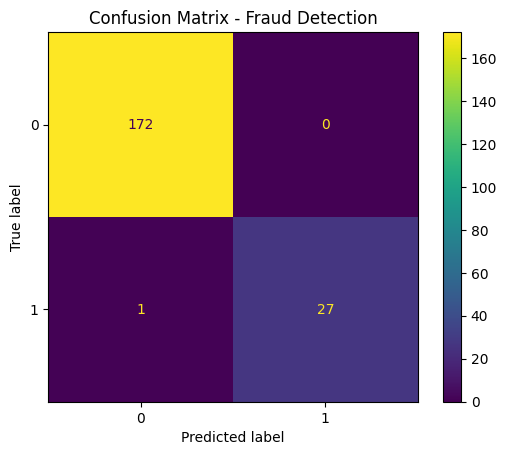

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title("Confusion Matrix - Fraud Detection")
plt.show()
